In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/home/antonius/Projects/DS_Projects/Check-ups/3_Machine_learning/data//churn-modeling.zip')

In [3]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
len(df)

10000

In [5]:
df.isna().mean()

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

In [6]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [7]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [8]:
df['Exited'].mean()

0.2037

# Обучающая, валидационная и тестовая выборка

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train, test = train_test_split(df,train_size=0.6,random_state=42,stratify=df['Exited'])

In [11]:
val, test = train_test_split(test,train_size=0.5,random_state=42,stratify=test['Exited'])

In [12]:
train['Exited'].mean()

0.20366666666666666

In [13]:
val['Exited'].mean()

0.204

In [14]:
test['Exited'].mean()

0.2035

# Phik

In [15]:
train_full = pd.concat([train,val])

In [16]:
train_full.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6851,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0
7026,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0


In [17]:
import phik

In [18]:
phik_overview = train_full.phik_matrix()

interval columns not set, guessing: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


/home/antonius/.local/lib/python3.10/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable Surname is large: 2591. Are you sure this is not an interval variable? Analysis for pairs of variables including Surname can be slow.
  warnings.warn(


In [19]:
phik_overview['Exited'].sort_values(ascending=False)

Exited             1.000000
NumOfProducts      0.564969
Age                0.498768
IsActiveMember     0.237244
Balance            0.167823
Gender             0.165231
CreditScore        0.105371
Geography          0.104047
CustomerId         0.035477
Tenure             0.030333
RowNumber          0.000000
Surname            0.000000
HasCrCard          0.000000
EstimatedSalary    0.000000
Name: Exited, dtype: float64

# Человеческое обучение

In [20]:
train_full.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6851,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0
7026,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0


In [21]:
train_full.groupby('NumOfProducts')['Exited'].agg(['count','mean'])

,count,mean
NumOfProducts,,
1,4060,0.275369
2,3673,0.077049
3,219,0.826484
4,48,1.000000


In [22]:
model = train_full.groupby('NumOfProducts')['Exited'].mean().reset_index()

In [23]:
model = model.rename({'Exited':'score_prod'},axis=1)

In [24]:
train_full = train_full.merge(model,how='left',on='NumOfProducts')

In [25]:
train_full.groupby('score_prod')['Exited'].agg(['count','mean'])

,count,mean
score_prod,,
0.077049,3673,0.077049
0.275369,4060,0.275369
0.826484,219,0.826484
1.000000,48,1.000000


# Baseline

In [26]:
train_full['score_mean'] = train_full['Exited'].mean()

In [27]:
from sklearn.metrics import log_loss

In [28]:
log_loss(train_full['Exited'],train_full['score_mean'])

0.5055572860042145

In [29]:
log_loss(train_full['Exited'],train_full['score_prod'])

0.4359616823203511

# Uplift

In [30]:
train_full.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod,score_mean
0,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0,0.077049,0.20375
1,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0,0.077049,0.20375


In [31]:
train_full['Exited'].mean()

0.20375

In [32]:
train_full['Exited'].sample(frac=0.5,random_state=42).mean()

0.20675

In [33]:
exited_all = train_full['Exited'].sum()

In [34]:
train_full['Exited'].sample(frac=0.2,random_state=42).sum()

337

In [35]:
train_full['Exited'].sample(frac=0.2,random_state=42).sum() / exited_all

0.2067484662576687

In [36]:
train_full = train_full.sort_values('score_prod',ascending=False)

In [37]:
round(len(train_full) * 0.2)

1600

In [38]:
train_full.head(round(len(train_full) * 0.2))['Exited'].sum() / exited_all

0.3576687116564417

In [39]:
0.3588957055214724 / 0.2067484662576687

1.7359050445103856

# Добавим шум

In [40]:
np.random.seed(42)
np.random.uniform(0,0.001,size=len(train_full))

array([0.00037454, 0.00095071, 0.00073199, ..., 0.00045533, 0.00090844,
       0.00010448])

In [41]:
np.random.seed(42)
train_full['score_prod'] = train_full['score_prod'] - np.random.uniform(0,0.001,size=len(train_full))

In [42]:
train_full['score_prod'].nunique()

8000

# Функция для uplift

In [43]:
exited_all = train_full['Exited'].sum()

In [44]:
train_full = train_full.sort_values('score_prod',ascending=False)

In [45]:
train_full.head(round(len(train_full) * 0.2))['Exited'].sum() / exited_all

0.3815950920245399

In [46]:
0.3815950920245399 / 0.2

1.9079754601226995

In [47]:
def uplift(df,score,pct):
  exited_all = df['Exited'].sum()
  df = df.sort_values(score,ascending=False)
  exited_found = df.head(round(len(df) * pct))['Exited'].sum()

  return (exited_found / exited_all) / pct

In [48]:
uplift(train_full,'score_prod',0.2)

1.9079754601226995

In [49]:
test = test.merge(model,how='left',on='NumOfProducts')

In [50]:
np.random.seed(42)
test['score_prod'] = test['score_prod'] - np.random.uniform(0,0.001,size=len(test))

In [51]:
log_loss(train_full['Exited'],train_full['score_prod'])

0.4359717821616623

In [52]:
log_loss(test['Exited'],test['score_prod'])

0.4338658337619006

In [53]:
uplift(test,'score_prod',0.2)

1.8427518427518426

# Добавим возраст

In [54]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

<AxesSubplot: >

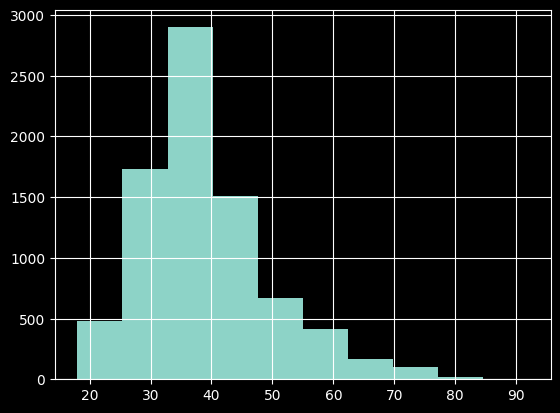

In [55]:
train_full['Age'].hist()

In [56]:
pd.qcut(train_full['Age'],5,retbins=True,labels=False)

(257     3
 3036    0
 4054    3
 3202    2
 1874    0
        ..
 94      0
 5637    3
 2489    3
 584     3
 2405    0
 Name: Age, Length: 8000, dtype: int64,
 array([18., 31., 35., 40., 46., 92.]))

In [57]:
train_full['age_group'] = pd.cut(train_full['Age'],[0,31,35,40,46,float('inf')])

In [58]:
train_full.groupby('age_group')['Exited'].agg(['count','mean'])

,count,mean
age_group,,
"(0.0, 31.0]",1896,0.075422
"(31.0, 35.0]",1424,0.091994
"(35.0, 40.0]",1797,0.146912
"(40.0, 46.0]",1376,0.289971
"(46.0, inf]",1507,0.459854


In [59]:
model = train_full.groupby(['NumOfProducts','age_group'])['Exited'].mean().reset_index() 

In [60]:
model = model.rename({'Exited':'score_prod_age'},axis=1)

In [61]:
model

,NumOfProducts,age_group,score_prod_age
0,1,"(0.0, 31.0]",0.106774
1,1,"(31.0, 35.0]",0.135908
2,1,"(35.0, 40.0]",0.198646
3,1,"(40.0, 46.0]",0.378873
4,1,"(46.0, inf]",0.542506
5,2,"(0.0, 31.0]",0.029293
6,2,"(31.0, 35.0]",0.031206
7,2,"(35.0, 40.0]",0.059977
8,2,"(40.0, 46.0]",0.106239
9,2,"(46.0, inf]",0.225869


In [62]:
train_full = train_full.merge(model,how='left',on=['NumOfProducts','age_group'])

In [63]:
train_full

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod,score_mean,age_group,score_prod_age
0,4512,15568006,Ukaegbunam,634,France,Female,45,2,0.00,4,1,0,101039.53,1,0.999979,0.20375,"(40.0, 46.0]",1.000000
1,4655,15593976,Swanson,578,Germany,Female,31,5,102088.68,4,0,0,187866.21,1,0.999966,0.20375,"(0.0, 31.0]",1.000000
2,4404,15616859,Bonwick,602,Germany,Female,43,2,113641.49,4,1,0,115116.35,1,0.999954,0.20375,"(40.0, 46.0]",1.000000
3,9412,15796115,Forbes,689,Germany,Female,40,4,78119.59,4,1,0,119259.34,1,0.999942,0.20375,"(35.0, 40.0]",1.000000
4,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,0.999935,0.20375,"(0.0, 31.0]",1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,9749,15680201,Marcelo,627,Germany,Male,24,5,102773.20,2,1,0,56793.02,1,0.076050,0.20375,"(0.0, 31.0]",0.029293
7996,3350,15603465,Dunn,665,Germany,Female,45,5,155447.65,2,1,0,51871.95,1,0.076050,0.20375,"(40.0, 46.0]",0.106239
7997,7652,15776921,Geoghegan,431,Germany,Male,45,5,83624.55,2,0,0,36899.62,0,0.076050,0.20375,"(40.0, 46.0]",0.106239
7998,7453,15636562,Muravyova,573,Spain,Male,44,8,0.00,2,0,0,62424.46,0,0.076049,0.20375,"(40.0, 46.0]",0.106239


In [64]:
log_loss(train_full['Exited'],train_full['score_prod'])

0.4359717821616623

In [65]:
uplift(train_full,'score_prod',0.2)

1.9079754601226995

In [66]:
log_loss(train_full['Exited'],train_full['score_prod_age'])

0.3866695862492173

In [67]:
uplift(train_full,'score_prod_age',0.2)

2.702453987730061

In [68]:
test['age_group'] = pd.cut(test['Age'],[0,31,35,40,46,float('inf')])

In [69]:
test = test.merge(model,how='left',on=['NumOfProducts','age_group'])

In [70]:
log_loss(test['Exited'],test['score_prod'])

0.4338658337619006

In [71]:
uplift(test,'score_prod',0.2)

1.8427518427518426

In [72]:
log_loss(test['Exited'],test['score_prod_age'])

0.3870707514157596

In [73]:
uplift(test,'score_prod_age',0.2)

2.7518427518427515

# Добавим IsActiveMember

In [74]:
train_full['IsActiveMember'].value_counts()

1    4131
0    3869
Name: IsActiveMember, dtype: int64

In [75]:
train_full.groupby('IsActiveMember')['Exited'].agg(['count','mean'])

,count,mean
IsActiveMember,,
0,3869,0.267511
1,4131,0.144033


In [76]:
model = train_full.groupby(['NumOfProducts','age_group','IsActiveMember'])['Exited'].mean().reset_index()

In [77]:
model = model.rename({'Exited':'score_prod_age_active'},axis=1)

In [78]:
train_full = train_full.merge(model,how='left',on=['NumOfProducts','age_group','IsActiveMember'])

In [79]:
test = test.merge(model,how='left',on=['NumOfProducts','age_group','IsActiveMember'])

In [80]:
def print_metrics(df,score):
  print(log_loss(df['Exited'],df[score]))
  print(uplift(df,score,0.2))

In [81]:
print_metrics(train_full,'score_prod_age')

0.3866695862492173
2.702453987730061


In [82]:
print_metrics(test,'score_prod_age')

0.3870707514157596
2.7518427518427515


In [83]:
print_metrics(train_full,'score_prod_age_active')

0.3655019751451003
2.861963190184049


In [84]:
print_metrics(test,'score_prod_age_active')

0.3638472889481342
2.862407862407862


# Машинное обучение

In [85]:
from catboost import CatBoostClassifier

In [86]:
train_full.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'score_prod',
       'score_mean', 'age_group', 'score_prod_age', 'score_prod_age_active'],
      dtype='object')

In [87]:
X = ['NumOfProducts','Age','IsActiveMember']
y = ['Exited']

In [88]:
params = {'verbose':100,
          'random_seed':42,
          'learning_rate':0.01}

In [89]:
model = CatBoostClassifier(**params)

In [90]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.6849803	test: 0.6849389	best: 0.6849389 (0)	total: 49.4ms	remaining: 49.3s
100:	learn: 0.3991169	test: 0.3930537	best: 0.3930537 (100)	total: 213ms	remaining: 1.89s
200:	learn: 0.3659581	test: 0.3563817	best: 0.3563817 (200)	total: 373ms	remaining: 1.48s
300:	learn: 0.3589224	test: 0.3476566	best: 0.3476566 (300)	total: 532ms	remaining: 1.24s
400:	learn: 0.3565171	test: 0.3446648	best: 0.3446648 (400)	total: 687ms	remaining: 1.03s
500:	learn: 0.3553274	test: 0.3433005	best: 0.3432984 (498)	total: 834ms	remaining: 830ms
600:	learn: 0.3544987	test: 0.3425379	best: 0.3425379 (600)	total: 986ms	remaining: 654ms
700:	learn: 0.3539638	test: 0.3421168	best: 0.3421135 (699)	total: 1.13s	remaining: 483ms
800:	learn: 0.3532817	test: 0.3419139	best: 0.3419139 (800)	total: 1.28s	remaining: 319ms
900:	learn: 0.3524351	test: 0.3416923	best: 0.3416923 (900)	total: 1.43s	remaining: 157ms
999:	learn: 0.3513546	test: 0.3417688	best: 0.3416551 (927)	total: 1.58s	remaining: 0us

bestTest = 0.3

In [91]:
test['score_cat_prod_age_active'] = model.predict_proba(test[X])[:,1]

In [92]:
test.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod,age_group,score_prod_age,score_prod_age_active,score_cat_prod_age_active
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,0.274995,"(0.0, 31.0]",0.106774,0.143885,0.127267
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,0.274419,"(31.0, 35.0]",0.135908,0.177650,0.160071


In [93]:
test['score_cat_prod_age_active'].nunique()

254

In [94]:
len(test)

2000

In [95]:
print_metrics(test,'score_prod_age_active')

0.3638472889481342
2.862407862407862


In [116]:
print_metrics(test,'score_cat_prod_age_active')

0.35878132799643003
2.899262899262899


In [118]:
import seaborn as sns

In [121]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [122]:
y_pred = model.predict_proba(test[X])[:,1]

In [124]:
test[y]

,Exited
0,0
1,0
2,0
3,0
4,0
...,...
1995,0
1996,0
1997,1
1998,0


In [ ]:
cm = confusion_matrix()

# Обучимся на всех фичах

In [97]:
train.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [98]:
train.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6851,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0
7026,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0


In [99]:
train.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [100]:
X = ['CustomerId', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']

cat_features = ['Geography','Gender']

y = ['Exited']
     

In [101]:
from catboost import Pool

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [102]:
params = {'verbose':100,
          'random_seed':42,
          'learning_rate':0.01}

In [103]:
model = CatBoostClassifier(**params)

In [104]:
model.fit(train_data,eval_set=valid_data)

0:	learn: 0.6848575	test: 0.6849145	best: 0.6849145 (0)	total: 10.5ms	remaining: 10.5s
100:	learn: 0.3908412	test: 0.3894043	best: 0.3894043 (100)	total: 514ms	remaining: 4.57s
200:	learn: 0.3457312	test: 0.3445503	best: 0.3445503 (200)	total: 996ms	remaining: 3.96s
300:	learn: 0.3288071	test: 0.3307084	best: 0.3307084 (300)	total: 1.47s	remaining: 3.42s
400:	learn: 0.3192987	test: 0.3252459	best: 0.3252459 (400)	total: 1.92s	remaining: 2.86s
500:	learn: 0.3120470	test: 0.3221057	best: 0.3221057 (500)	total: 2.42s	remaining: 2.41s
600:	learn: 0.3054735	test: 0.3204300	best: 0.3204300 (600)	total: 2.86s	remaining: 1.9s
700:	learn: 0.2997053	test: 0.3192377	best: 0.3192377 (700)	total: 3.33s	remaining: 1.42s
800:	learn: 0.2946934	test: 0.3188206	best: 0.3187917 (794)	total: 3.81s	remaining: 948ms
900:	learn: 0.2890177	test: 0.3185731	best: 0.3185731 (900)	total: 4.26s	remaining: 468ms
999:	learn: 0.2831978	test: 0.3186396	best: 0.3185004 (978)	total: 4.71s	remaining: 0us

bestTest = 0.31

In [105]:
test['score_cat_prod_age_active_all_features'] = model.predict_proba(test[X])[:,1]

In [106]:
print_metrics(test,'score_cat_prod_age_active')

0.35878132799643003
2.899262899262899


In [107]:
print_metrics(test,'score_cat_prod_age_active_all_features')

0.3296082204006806
3.1449631449631448


# Feature importances

In [108]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,NumOfProducts,27.408724
1,Age,21.567747
2,Balance,11.455919
3,Geography,10.011145
4,IsActiveMember,7.420335
5,EstimatedSalary,5.163513
6,CustomerId,4.965796
7,CreditScore,4.482999
8,Tenure,3.637201
9,Gender,3.089379


In [109]:
phik_overview['Exited'].sort_values(ascending=False)

Exited             1.000000
NumOfProducts      0.564969
Age                0.498768
IsActiveMember     0.237244
Balance            0.167823
Gender             0.165231
CreditScore        0.105371
Geography          0.104047
CustomerId         0.035477
Tenure             0.030333
RowNumber          0.000000
Surname            0.000000
HasCrCard          0.000000
EstimatedSalary    0.000000
Name: Exited, dtype: float64

# Классификция == Регрессия (технически)

In [110]:
model.predict(test[X],prediction_type='RawFormulaVal')

array([-1.88475323, -2.52652396, -1.47044046, ..., -1.73922605,
       -2.68750234, -2.93959577])

<AxesSubplot: >

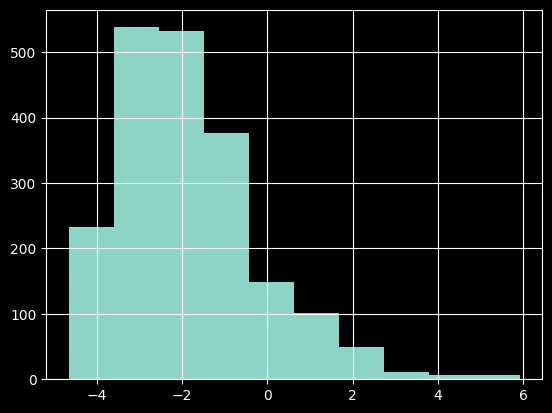

In [111]:
pd.Series(model.predict(test[X],prediction_type='RawFormulaVal')).hist()

In [112]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [113]:
pd.Series(model.predict(test[X],prediction_type='RawFormulaVal')).apply(sigmoid)

0       0.131844
1       0.074020
2       0.186876
3       0.087403
4       0.056658
          ...   
1995    0.026803
1996    0.084712
1997    0.149411
1998    0.063715
1999    0.050231
Length: 2000, dtype: float64

In [114]:
model.predict_proba(test[X])

array([[0.86815614, 0.13184386],
       [0.92598046, 0.07401954],
       [0.81312433, 0.18687567],
       ...,
       [0.85058873, 0.14941127],
       [0.93628515, 0.06371485],
       [0.94976945, 0.05023055]])

In [115]:
model.predict(test[X],prediction_type='Probability')

array([[0.86815614, 0.13184386],
       [0.92598046, 0.07401954],
       [0.81312433, 0.18687567],
       ...,
       [0.85058873, 0.14941127],
       [0.93628515, 0.06371485],
       [0.94976945, 0.05023055]])